## DATA 558: Data Competition 2

### Logistic Regression Models (Prompt from HW6)

Geoffrey Li



In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import datetime
import random
from timeit import default_timer as timer
import pickle

### 1: Define Functions

In [2]:
def computegrad(x, y, beta, lamb):
    p = np.identity(len(x)) - np.diag(1/(1+np.exp(np.multiply(-y, x@beta))).reshape(1, -1)[0])
    return -1/len(x) * x.T @ p @ y + 2*lamb*beta


def computeobj(x, y, beta, lamb):
    return 1/(len(x))*np.sum(np.log(1+np.exp(np.multiply(-y, x@beta)))) + lamb*np.sum(beta**2)


def backtracking(curr_beta, lamb, x, y, eta_t=1, alpha=0.5, gamma=0.5, max_iter=100):
    grad_curr_beta = computegrad(x, y, curr_beta, lamb)  # Gradient at current beta
    norm_grad_curr_beta = np.sqrt(np.sum(grad_curr_beta ** 2))  # Norm of the gradient at current beta
    found_eta_t = False
    i = 0  # Iteration counter

    while (found_eta_t is False and i < max_iter):
        if (computeobj(x, y, curr_beta - eta_t * grad_curr_beta, lamb) <
                computeobj(x, y, curr_beta, lamb) - alpha * eta_t * norm_grad_curr_beta ** 2):
            found_eta_t = True
        elif i == max_iter - 1:
            raise ('Maximum number of iterations of backtracking reached')
        else:
            eta_t *= gamma
            i += 1

    return eta_t


def initstepsize(x, lamb):
    return 1/(max(np.linalg.eigh(1/len(x)*x.T@x)[0]) + lamb)


def fastgradalgo(beta_init, lamb, x, y, theta_init, ss_init, targ_acc, max_iter=1000):
    beta_values = list()
    beta_values.append(beta_init)
    theta = theta_init

    grad_theta = computegrad(x, y, theta, lamb)
    grad_beta = computegrad(x, y, beta_init, lamb)
    norm_grad_beta = np.sqrt(np.sum(grad_beta ** 2))

    tuned_step_size = ss_init

    t = 0

    while t < max_iter and norm_grad_beta > targ_acc:
        grad_theta = computegrad(x, y, theta, lamb)

        tuned_step_size = backtracking(beta_values[t], lamb, x, y, 
                                       eta_t=tuned_step_size, alpha=0.5, gamma=0.8, max_iter=20)

        beta_values.append(theta - tuned_step_size * grad_theta)
        theta = beta_values[t + 1] + (t / (t + 3)) * (beta_values[t + 1] - beta_values[t])

        t += 1

        grad_beta = computegrad(x, y, beta_values[t], lamb)
        norm_grad_beta = np.sqrt(np.sum(grad_beta ** 2))

    return beta_values


def misclassificationerror(y, x, b):
    return 1 - np.mean(
        np.fromiter(map(lambda p: 1 if p >= 0.5 else -1, 1/(1+np.exp(-x@b))), 
                    dtype=np.int).reshape(-1,1) == y)

def misclassificationerror_transform(y, x, b, pos_class, neg_class):
    return 1 - np.mean(
        np.fromiter(map(lambda p: pos_class if p >= 0.5 else neg_class, 1/(1+np.exp(-x@b))), 
                    dtype=np.int) == y)

In [3]:
def predict_transform(x, b, pos_class, neg_class):
    return np.fromiter(map(lambda p: pos_class if p >= 0.5 else neg_class, 1/(1+np.exp(-x@b))), dtype=np.int)

In [4]:
def mylogistic(x_train, y_train, init_eta, target_accuracy, lamb):
    init_beta = np.zeros(x_train.shape[1])[:, np.newaxis]
    init_theta = np.zeros(x_train.shape[1])[:, np.newaxis]
    
    # Run fast gradient and train classifier
    beta_opt = fastgradalgo(init_beta, lamb, x_train, y_train, init_theta, init_eta, target_accuracy, max_iter=1000)
    beta_opt_T = beta_opt[len(beta_opt)-1]
    
    return beta_opt_T

### 2: Loading and processing data

In [5]:
path = './data/'

In [6]:
X_train = np.load(path+'train_features.npy')
y_train = np.load(path+'train_labels.npy')

X_val = np.load(path+'val_features.npy')
y_val = np.load(path+'val_labels.npy')

X_test = np.load(path+'test_features.npy')

In [7]:
# Standardize the data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [8]:
# Subsets training and validation data based on input classes
def subset_data(pos_class, neg_class, X_train, y_train, X_val=None, y_val=None):
    train_subset = (y_train == pos_class) | (y_train == neg_class)
    y_train_subset = y_train[np.where(train_subset)]
    X_train_subset = X_train[train_subset.nonzero()[0]]
    y_train_subset = np.fromiter(map(lambda n: 1 if n == pos_class else -1, y_train_subset), dtype=int).reshape(-1, 1)
   
    if X_val != None and y_val != None:
        val_subset = (y_val == pos_class) | (y_val == neg_class)
        y_val_subset = y_val[np.where(val_subset)]
        X_val_subset = X_val[val_subset.nonzero()[0]]
        y_val_subset = np.fromiter(map(lambda n: 1 if n == pos_class else -1, y_val_subset), dtype=int).reshape(-1, 1)
        return X_train_subset, y_train_subset, X_val_subset, y_val_subset
    
    return X_train_subset, y_train_subset

Subset training and val data to class 1 as the positive class and class 0 as the negative class.

In [16]:
X_train_subset, y_train_subset, X_val_subset, y_val_subset = subset_data(1, 0, X_train, y_train, X_val, y_val)

### 3: Training model with default params

Pick two classes of your choice from the dataset. Train an L2-regularized logistic regression classifier on the training set using your own fast gradient algorithm with $\lambda = 1$.


Initialize and train classifier.

In [17]:
# Initialize fast gradient
init_beta = np.zeros(X_train_subset.shape[1])[:, np.newaxis]
init_theta = np.zeros(X_train_subset.shape[1])[:, np.newaxis]
lambduh = 1
target_accuracy = 10**-3
init_eta = initstepsize(X_train_subset, lambduh)

# Train classifier
beta_opt_naive = fastgradalgo(init_beta, lambduh, X_train_subset, y_train_subset, 
                              init_theta, init_eta, target_accuracy)

beta_opt_naive_T = beta_opt_naive[len(beta_opt_naive)-1]

Plot, with different colors, the misclassification error on the training set and on the validation set vs iterations.


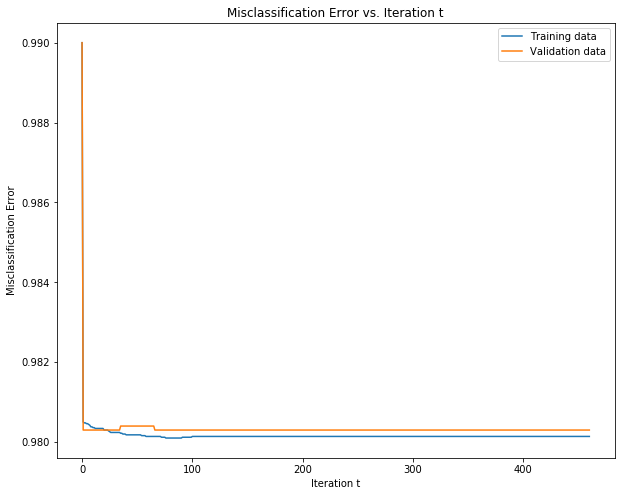

In [18]:
# Plot misclassification error
plt.figure(figsize=(10,8))
plt.plot(range(0,len(beta_opt_naive)),
         list(map(lambda b: misclassificationerror_transform(y_train,X_train,b,1,0),beta_opt_naive)))
plt.plot(range(0,len(beta_opt_naive)),
         list(map(lambda b: misclassificationerror_transform(y_val,X_val,b,1,0),beta_opt_naive)))
plt.legend(['Training data', 'Validation data'], loc='upper right')
plt.title('Misclassification Error vs. Iteration t')
plt.xlabel('Iteration t')
plt.ylabel('Misclassification Error');

In the above plot, we see that the misclassification error on the training data and validation data quickly approach 0.98. This makes sense as we only chose 2 classes out of 100 for our model. At best, we should expect to predict correctly for 2 out of 100 classes, leading to a misclassification error of 0.98 (since we have a balanced multi-class classification task).

For the training data, our model appears to stabilize at around 100 iterations.

In [36]:
y_preds = predict_transform(X_test, beta_opt_naive_T, 1, 0)
pd.DataFrame({'preds':y_preds}).groupby('preds').size()

preds
0    5266
1    4734
dtype: int64

In [29]:
pd.DataFrame({'Category':y_preds}).reset_index()\
.rename(columns={'index':'Id'}).to_csv('./comp2-subm_log-lam1.csv', index=False)

Misclassification Error on Test Set (from Kaggle): 0.98

### 4: Training model with opt $\lambda$

Find the value of the regularization parameter $\lambda$ using cross-validation; you may use scikit-learn’s built-in functions for this purpose. Train an L2-regularized logistic regression classifier on the training set using your own fast gradient algorithm with that value of $\lambda$ found by cross-validation.

In [31]:
from sklearn.linear_model import LogisticRegressionCV

clf = LogisticRegressionCV(Cs=10, penalty='l2', fit_intercept=False, cv=5)
clf.fit(X_train_subset, y_train_subset)
clf.score(X_val_subset, y_val_subset)

/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.985

Our L2-regularized logistic regression classifier appears to perform well on the 2-class subset, with a score of 0.985 (misclassification error of 0.015).

In [32]:
clf.score(X_val, y_val)

0.0099

In [42]:
print("Best C:", clf.C_[0])
print("Best Lamba: ",1/(clf.C_[0]*len(X_train_subset)*2))
opt_lamb = 1/(clf.C_[0]*len(X_train_subset)*2)

Best C: 0.000774263682681127
Best Lamba:  0.6457748325074419


#### Train Model

Now we train our L2-regularized logistic regression classifier with the optimal lambda we found above using sklearn.

In [37]:
# Initialize fast gradient
init_beta = np.zeros(X_train_subset.shape[1])[:, np.newaxis]
init_theta = np.zeros(X_train_subset.shape[1])[:, np.newaxis]
lambduh = opt_lamb
target_accuracy = 10**-3
init_eta = initstepsize(X_train_subset, lambduh)

# Train classifier
beta_opt = fastgradalgo(init_beta, lambduh, X_train_subset, y_train_subset, 
                              init_theta, init_eta, target_accuracy)

beta_opt_T = beta_opt[len(beta_opt)-1]

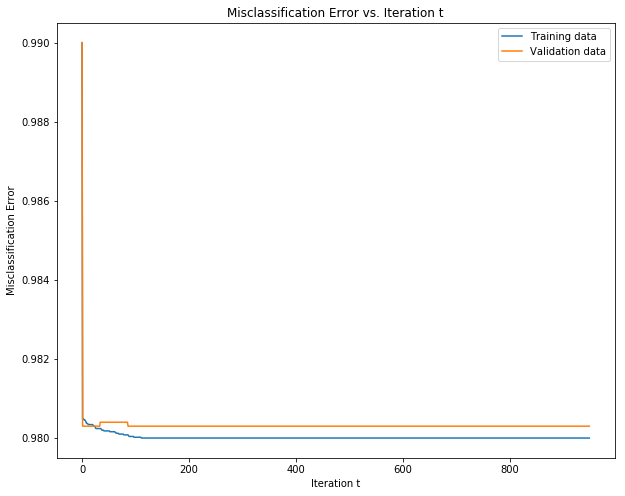

In [41]:
# Plot misclassification error
plt.figure(figsize=(10,8))
plt.plot(range(0,len(beta_opt)),
         list(map(lambda b: misclassificationerror_transform(y_train,X_train,b,1,0),beta_opt)))
plt.plot(range(0,len(beta_opt)),
         list(map(lambda b: misclassificationerror_transform(y_val,X_val,b,1,0),beta_opt)))
plt.legend(['Training data', 'Validation data'], loc='upper right')
plt.title('Misclassification Error vs. Iteration t')
plt.xlabel('Iteration t')
plt.ylabel('Misclassification Error');

We see a similar story as above, our models approach a misclassifiaction error of approximately 0.98 at around 100 iterations (on the training data).

In [ ]:
y_preds = predict_transform(X_test, beta_opt_T, 1, 0)
pd.DataFrame({'preds':y_preds}).groupby('preds').size()

In [ ]:
pd.DataFrame({'Category':y_preds}).reset_index()\
.rename(columns={'index':'Id'}).to_csv('./comp2-subm_log-lam-opt.csv', index=False)

Misclassification Error on Test Set (from Kaggle): 0.98

### 5: Training with pairwise Logistic Classifiers

In this section I'm trying something beyond the scope of the prompt. Here I'm training 4,950 pariwise one-vs-one (OVO) L2-regularized logistic regression classifiers using my own home-grown classifier. Predictions are found using majority vote, with ties broken by random choice.

In [ ]:
# Initialize fast gradient
target_accuracy = 10**-2
opt_lamb_pairwise = list()
classes = 100

# Store trained beta values in a list of length 100, one entry for each pairwise classifier
pairwise_clfs = dict()

for i in range(classes):
    for j in range(i+1, classes):
        print('Training ('+str(i)+','+str(j)+') model...')
        X_train_subset, y_train_subset, X_val_subset, y_val_subset = subset_data(i, j, X_train, y_train, X_val, y_val)
        init_beta = np.zeros(X_train_subset.shape[1])[:, np.newaxis]
        init_theta = np.zeros(X_train_subset.shape[1])[:, np.newaxis]
        
        # Run CV to find optimal lambda
#         clf = LogisticRegressionCV(Cs=10, penalty='l2', fit_intercept=False, cv=5)
#         clf.fit(X_train_subset, y_train_subset)
#         opt_lamb = 1/(clf.C_[0]*len(X_train_subset)*2)
        opt_lamb = 1
        
        
        opt_lamb_pairwise.append(opt_lamb)
        init_eta = initstepsize(X_train_subset, opt_lamb)
        
        # Train classifier
        beta_opt_pairwise = fastgradalgo(init_beta, opt_lamb, X_train_subset, y_train_subset, 
                                         init_theta, init_eta, target_accuracy, max_iter=20)
        
        pairwise_clfs[(i, j)] = beta_opt_pairwise[len(beta_opt_pairwise)-1]

                

Training (0,1) model...
Training (0,2) model...
Training (0,3) model...
Training (0,4) model...
Training (0,5) model...
Training (0,6) model...
Training (0,7) model...
Training (0,8) model...
Training (0,9) model...
Training (0,10) model...
Training (0,11) model...
Training (0,12) model...
Training (0,13) model...
Training (0,14) model...
Training (0,15) model...
Training (0,16) model...
Training (0,17) model...
Training (0,18) model...
Training (0,19) model...
Training (0,20) model...
Training (0,21) model...
Training (0,22) model...
Training (0,23) model...
Training (0,24) model...
Training (0,25) model...
Training (0,26) model...
Training (0,27) model...
Training (0,28) model...
Training (0,29) model...
Training (0,30) model...
Training (0,31) model...
Training (0,32) model...
Training (0,33) model...
Training (0,34) model...
Training (0,35) model...
Training (0,36) model...
Training (0,37) model...
Training (0,38) model...
Training (0,39) model...
Training (0,40) model...
Training 

Training (3,39) model...
Training (3,40) model...
Training (3,41) model...
Training (3,42) model...
Training (3,43) model...
Training (3,44) model...
Training (3,45) model...
Training (3,46) model...
Training (3,47) model...
Training (3,48) model...
Training (3,49) model...
Training (3,50) model...
Training (3,51) model...
Training (3,52) model...
Training (3,53) model...
Training (3,54) model...
Training (3,55) model...
Training (3,56) model...
Training (3,57) model...
Training (3,58) model...
Training (3,59) model...
Training (3,60) model...
Training (3,61) model...
Training (3,62) model...
Training (3,63) model...
Training (3,64) model...
Training (3,65) model...
Training (3,66) model...
Training (3,67) model...
Training (3,68) model...
Training (3,69) model...
Training (3,70) model...
Training (3,71) model...
Training (3,72) model...
Training (3,73) model...
Training (3,74) model...
Training (3,75) model...
Training (3,76) model...
Training (3,77) model...
Training (3,78) model...


In [9]:
def majority_vote(array):
    most = max(list(map(array.count, array)))
    return random.choice(list(set(filter(lambda x: array.count(x) == most, array))))

In [10]:
def predict_pairwise(betas, x):
    preds = list(map(lambda p: p[0] if 1/(1+np.exp(-x@betas[p])) > 0.5 else p[1], betas))
    return majority_vote(preds)

In [ ]:
# Validation set predictions
y_val_preds = list(map(lambda n: predict_pairwise(pairwise_clfs, n), X_val))

# Misclassification Error Rate for Validation Set
1 - np.mean(y_val_preds == y_val)

In [ ]:
# Test set predictions
y_test_preds = list(map(lambda n: predict_pairwise(pairwise_clfs, n), X_test))

# Write to CSV for Kaggle submission
pd.DataFrame({'Category':y_test_preds}).reset_index()\
             .rename(columns={'index':'Id'}).to_csv('./comp2-subm_log-pairwise.csv', index=False)

Misclassification Error on Test Set (from Kaggle): 0.45 

Comments: not bad! Our accuracy was 0.55. Let's try with sklearn, since training time took awhile and sklearn appears to be slightly more optimized.

### Pairwise Predictions with sklearn.linear_model.LogisticRegressionCV

In this section I'm training 4,950 pairwise one-vs-one (OVO) L2-regularized logistic regression classifiers with optimal lambdas found using cross-validation. Predictions are found using majority vote, with ties broken by random choice.

In [ ]:
from sklearn.linear_model import LogisticRegressionCV

maxiter = 1000
target_accuracy = 1e-5
classes = 100
pairwise_clfs_sk = dict()
opt_lamb_pairwise_sk = dict()
t = 0

for i in range(classes):
    for j in range(i+1, classes):
        print('Training model '+str(t)+': ('+str(i)+','+str(j)+') ...')
        start = timer()
        X_train_subset, y_train_subset = subset_data(i, j, X_train, y_train)
        
        clf = LogisticRegressionCV(penalty='l2', Cs=10, cv=5, 
                                   fit_intercept=False, max_iter=maxiter, tol=target_accuracy)
        clf.fit(X_train_subset, y_train_subset.squeeze())
        
        pairwise_clfs_sk[(i, j)] = clf
        opt_lamb_pairwise_sk[(i, j)] = clf.C_[0]
        
        end = timer()
        print(end - start)
        t += 1
        

Training model 0: (0,1) ...
2.269513574981829
Training model 0: (0,2) ...
2.143749234994175
Training model 0: (0,3) ...
1.7185978879861068
Training model 0: (0,4) ...
1.5827356700028758
Training model 0: (0,5) ...
1.4544363610039
Training model 0: (0,6) ...
2.048685435001971
Training model 0: (0,7) ...
1.4625382960075513
Training model 0: (0,8) ...
1.7417152500129305
Training model 0: (0,9) ...
1.4613639099989086
Training model 0: (0,10) ...
1.3737677090102807
Training model 0: (0,11) ...
1.4739647739916109
Training model 0: (0,12) ...
1.2806072810199112
Training model 0: (0,13) ...
1.8573483219952323
Training model 0: (0,14) ...
1.470893492019968
Training model 0: (0,15) ...
1.74674628500361
Training model 0: (0,16) ...
1.588332448998699
Training model 0: (0,17) ...
1.4057825930067338
Training model 0: (0,18) ...
1.3344219439895824
Training model 0: (0,19) ...
1.3688303510134574
Training model 0: (0,20) ...
1.615255647979211
Training model 0: (0,21) ...
1.3663102469872683
Training mod

In [ ]:
def predict_pairwise_sk(clfs, x):
    preds = list(map(lambda c: c[0] if clfs[c].predict(x.reshape(1, -1)) == 1 else c[1], clfs))
    return majority_vote(preds)

In [ ]:
# Validation set predictions
y_val_preds_sk = list(map(lambda n: predict_pairwise_sk(pairwise_clfs_sk, n), X_val))

# Misclassification Error Rate for Validation Set
1 - np.mean(y_val_preds_sk == y_val)

In [ ]:
# Test set predictions
y_test_preds_sk = list(map(lambda n: predict_pairwise_sk(pairwise_clfs_sk, n), X_test))

# Write to CSV for Kaggle submission
pd.DataFrame({'Category':y_test_preds_sk}).reset_index()\
             .rename(columns={'index':'Id'}).to_csv('./comp2-subm_log-pairwise-sk.csv', index=False)

# Write trained models to pickle file
pickle.dump( pairwise_clfs_sk, open( "pairwise_clfs_sk.p", "wb" ) )

# Write optimal lambdas to pickle file
pickle.dump( opt_lamb_pairwise_sk, open( "opt_lamb_pairwise_sk.p", "wb" ) )



Misclassification Error on Test Set (from Kaggle): 0.429

With an accuracy of 0.57099 on Kaggle, I'm pleased with the result! It looks like the optimal lambdas and lowered tolerance resulted in a few more percentage points of performance.